# Evaluation Analysis for Recommender Output

In this section we will analyze and compare the generated recommendations and predictions from a predefined list of algorithms with the goal of assessing the performance of each algorithm with respect to a metric. In other words, we would rank the algorithms for each metric considered with respect to performance.

## Setup

Below are the list of packages required to successfully run the analysis. They are divided into partitions to signify their specific task.<br>
We need the pathlib package for working with files and folders

In [1]:
from pathlib import Path
import json

We would use the pandas for analyzing and manipulating our data while seaborn and matplotlib are used for data visualization. statsmodels.graphics.gofplots and scipy.stats.shapiro are used for normality check. Scipy.stats.friedmanchisquare is a non-parametric test used to determine the statistical significance in metric results and the wilcoxon test is used for pairwise comparison of sample data.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro
from scipy.stats import friedmanchisquare, wilcoxon
from itertools import combinations

Import the LensKit metrics for analysis:

In [3]:
from lenskit.data import ItemListCollection, UserIDKey
from lenskit.metrics import RunAnalysis, RMSE, NDCG, RecipRank, RBP

## Load Data

The recommendations are in `runs`, and we will need to reassemble the test data from `test`.

In [4]:
dataset = "ml100k"

In [5]:
# Parameters
dataset = "ml32m"


In [6]:
output_root = Path("runs")

In [7]:
dirs = [fld for fld in output_root.glob(f'{dataset}-*')]

In [8]:
recs = ItemListCollection(['model', 'user_id'], index=False)
for fld in dirs:
    for file in fld.glob("recs-*"):
        rec = pd.read_parquet(file)
        rec = ItemListCollection.from_df(rec, UserIDKey)
        recs.add_from(rec, model=fld.name.split("-")[1])

In [9]:
rec_algos = sorted(set(a for (a, _u) in recs.keys()))
rec_algos

['ALS', 'Bias', 'IALS', 'IIE', 'III', 'Pop']

In [10]:
preds = ItemListCollection(['model', 'user_id'], index=False)
for fld in dirs:
    for file in fld.glob("pred-*"):
        pred = pd.read_parquet(file)
        pred = ItemListCollection.from_df(pred, UserIDKey)
        preds.add_from(pred, model=fld.name.split("-")[1])

We need to load the test data so that we have the ground truths for computing accuracy

In [11]:
split_root = Path("data-split")
split_dir = split_root / dataset

In [12]:
test = ItemListCollection(UserIDKey)
for file in split_dir.glob("test-*.parquet"):
    df = pd.read_parquet(file)
    test.add_from(ItemListCollection.from_df(df, UserIDKey))

## Top-N Metrics

`RunListAnalysis` computes metrics for recommendation results and takes care of
matching recommendations and ground truth.

In [13]:
ra = RunAnalysis()

ra.add_metric(NDCG())
ra.add_metric(RecipRank())
ra.add_metric(RBP())

rec_results = ra.compute(recs, test)
rec_results.list_summary('model')

/home/mde48/lenskit/lk-demo-experiment/.pixi/envs/cuda/lib/python3.12/site-packages/lenskit/metrics/bulk.py:116: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = scores.groupby(list(keys)).agg(["mean", "median", "std"]).stack(level=0)


mean        median       std
model                                            
ALS   NDCG       0.015639  0.000000e+00  0.041319
      RBP        0.002333  0.000000e+00  0.026929
      RecipRank  0.012426  0.000000e+00  0.060284
Bias  NDCG       0.029528  0.000000e+00  0.050135
      RBP        0.002784  0.000000e+00  0.016395
      RecipRank  0.021874  0.000000e+00  0.056266
IALS  NDCG       0.258671  2.127080e-01  0.191885
      RBP        0.121836  1.953363e-03  0.210022
      RecipRank  0.265175  1.111111e-01  0.328981
IIE   NDCG       0.001373  0.000000e+00  0.010782
      RBP        0.000034  0.000000e+00  0.002521
      RecipRank  0.000587  0.000000e+00  0.007555
III   NDCG       0.226666  1.652725e-01  0.204686
      RBP        0.150927  1.586914e-03  0.236827
      RecipRank  0.302247  1.000000e-01  0.374646
Pop   NDCG       0.129194  8.857376e-02  0.140090
      RBP        0.064584  7.450581e-09  0.153568
      RecipRank  0.159087  3.703704e-02  0.276221

We can reshape the list metrics and plot them:

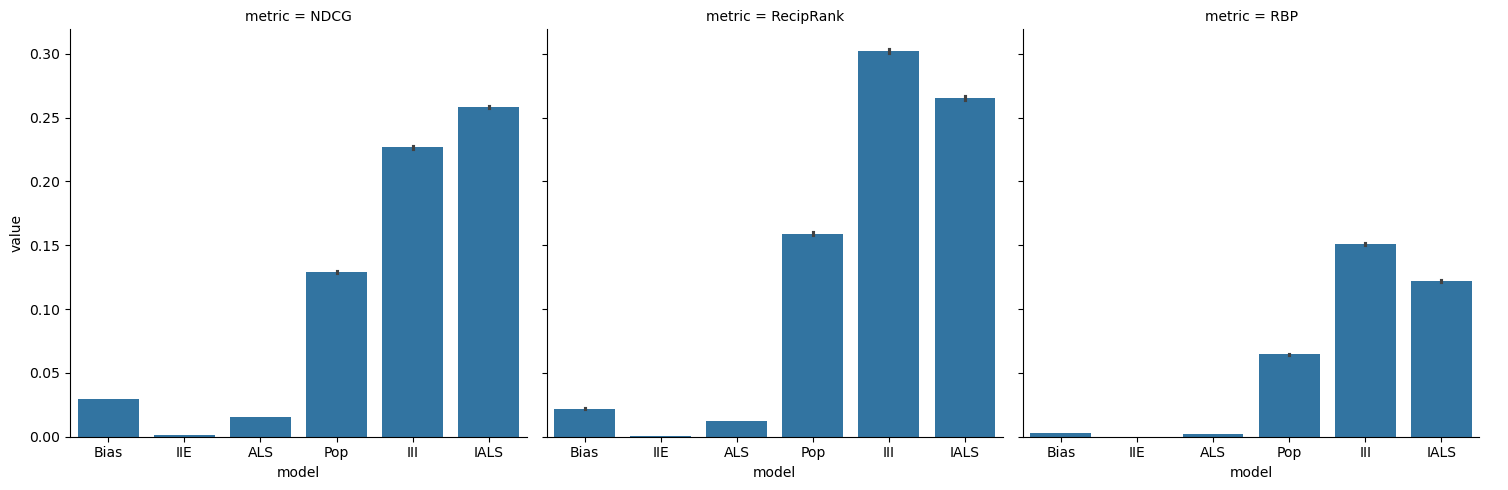

In [14]:
metrics = rec_results.list_metrics()
metrics = metrics.melt(var_name='metric', ignore_index=False).reset_index()
sns.catplot(metrics, x='model', y='value', col='metric', kind='bar')
plt.show()

## Prediction RMSE

We will also look at the prediction RMSE.

In [15]:
pa = RunAnalysis()

pa.add_metric(RMSE(missing_scores='ignore', missing_truth='ignore'))

pred_results = pa.compute(preds, test)
pred_results.list_summary('model')

/home/mde48/lenskit/lk-demo-experiment/.pixi/envs/cuda/lib/python3.12/site-packages/lenskit/metrics/bulk.py:116: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = scores.groupby(list(keys)).agg(["mean", "median", "std"]).stack(level=0)


,,mean,median,std
model,,,,
ALS,RMSE,0.762725,0.698439,0.356365
Bias,RMSE,0.810034,0.741199,0.375163
IIE,RMSE,0.746687,0.682737,0.355903


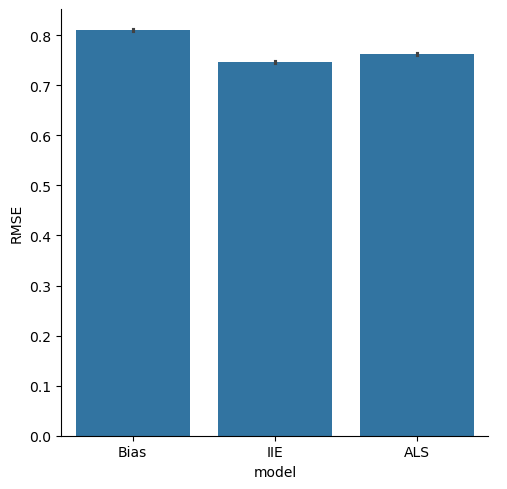

In [16]:
sns.catplot(pred_results.list_metrics().reset_index(), x='model', y='RMSE', kind='bar')
plt.show()

## Save Metrics

We'll now save the metrics to a file.

In [17]:
rlsum = rec_results.list_summary('model')['mean'].unstack()
rlsum

/home/mde48/lenskit/lk-demo-experiment/.pixi/envs/cuda/lib/python3.12/site-packages/lenskit/metrics/bulk.py:116: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = scores.groupby(list(keys)).agg(["mean", "median", "std"]).stack(level=0)


,NDCG,RBP,RecipRank
model,,,
ALS,0.015639,0.002333,0.012426
Bias,0.029528,0.002784,0.021874
IALS,0.258671,0.121836,0.265175
IIE,0.001373,0.000034,0.000587
III,0.226666,0.150927,0.302247
Pop,0.129194,0.064584,0.159087


In [18]:
rlsum.to_json(f'eval-metrics.{dataset}.json', orient='index')